In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Setup paths to data directory
BASE_DIR = os.path.abspath('')  
DATA_DIR = os.path.join(BASE_DIR, 'data')


In [9]:
# Inspect the Parquet file schema to find feature columns & label
pf = pq.ParquetFile(os.path.join(DATA_DIR, 'train.parquet'))
print("Columns:", pf.schema.names[:10], "…", "Label at index:", pf.schema.names.index('Label'))

# Select all columns that are not internal (no leading '_') and not the label
feature_cols = [c for c in pf.schema.names if not c.startswith('_') and c != 'Label']

# One row dataframe
one_row = df.head(1)
print(one_row.to_string(index=False))

Columns: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10'] … Label at index: 2381
      F1       F2       F3       F4       F5  Label
0.014676 0.004222 0.003923 0.004029 0.004007    0.0


(799912, 6)
Label
 0.0    0.375030
 1.0    0.374952
-1.0    0.250018
Name: proportion, dtype: float64


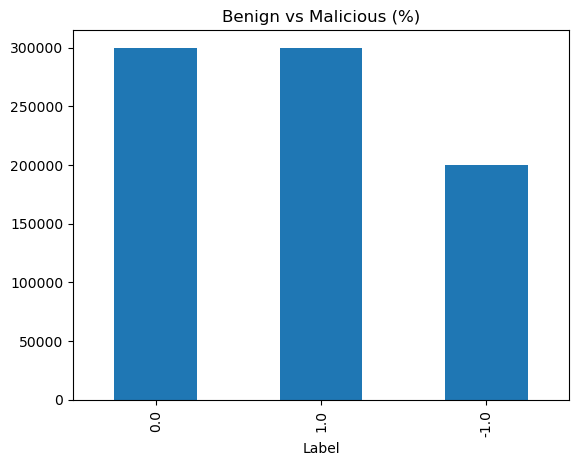

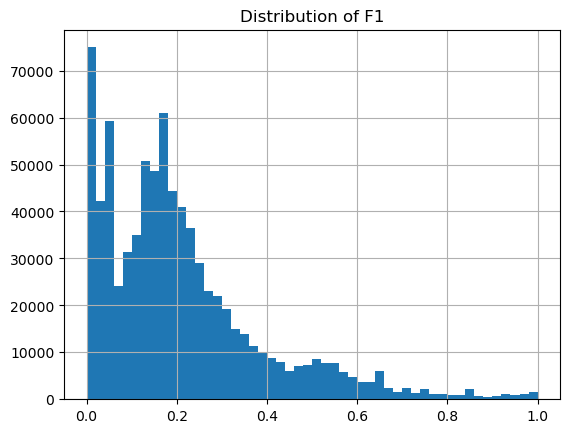

In [3]:
# Looking at the first few features + label

cols = feature_cols[:5] + ['Label']   # just pick first 5 features + label
df = pd.read_parquet(os.path.join(DATA_DIR, 'train.parquet'), columns=cols)

print(df.shape)  # (n_samples, 6)
print(df['Label'].value_counts(normalize=True))  # relative frequencies

# Plot class balance
df['Label'].value_counts().plot.bar(title="Benign vs Malicious (%)")
plt.show()

# Plot distribution of the first feature
df[cols[0]].hist(bins=50)
plt.title(f"Distribution of {cols[0]}")
plt.show()


In [4]:
# Define a PyTorch Dataset for EMBER data

class EmberDataset(Dataset):
    def __init__(self, path, feature_cols, scaler=None):
        """
        path:         path to parquet file
        feature_cols: list of feature column names
        scaler:       sklearn StandardScaler to reuse on val/test split
        """
        
        # Read only the needed columns + Label
        df = pd.read_parquet(path, columns=feature_cols + ['Label'])
        X = df[feature_cols].to_numpy(dtype='float32')  # features
        y = df['Label'].to_numpy(dtype='float32')  # binary label
        
        # Fit a new scaler on training data if none provided
        if scaler is None:
            self.scaler = StandardScaler().fit(X)
        else:
            self.scaler = scaler
            
        # Apply scaling
        X = self.scaler.transform(X)
        
        # Convert to PyTorch tensors
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).unsqueeze(1)  # shape (N,1)

    def __len__(self):
        # Return number of samples
        return len(self.y)

    def __getitem__(self, idx):
        # Retrieve one sample (features, label)
        return self.X[idx], self.y[idx]

# Instantiate train & validation datasets
train_ds = EmberDataset(os.path.join(DATA_DIR, 'train.parquet'), feature_cols)

# Reuse train scaler for validation
val_ds   = EmberDataset(os.path.join(DATA_DIR, 'test.parquet'),  feature_cols, scaler=train_ds.scaler)

# Wrap datasets in DataLoaders for batching
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True,
    num_workers=0,       # ← force single‐process loading
)

val_loader = DataLoader(
    val_ds,
    batch_size=256,
    shuffle=False,
    num_workers=0,       
)


print(f"Train samples: {len(train_ds):,}, features: {len(feature_cols)}")


Train samples: 799,912, features: 2381


In [5]:
# Define a Fully-Connected Neural Network

class FCNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # A 4-layer MLP with BatchNorm, ReLU, and Dropout between layers
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(1024, 512),       nn.BatchNorm1d(512),  nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, 256),        nn.BatchNorm1d(256),  nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 1)  # final logit output
        )

    def forward(self, x):
        return self.net(x)

# Choose device (GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FCNN(len(feature_cols)).to(device)

# Binary classification loss + Adam optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [6]:
# Training & Evaluation Functions

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


def train_epoch():
    """
    Run one training epoch and return average loss.
    """
    model.train()
    running_loss = 0.0
    for X,y in train_loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    return running_loss / len(train_loader.dataset)

def eval_metrics(loader):
    """
    Evaluate precision, recall, F1, and ROC AUC on given DataLoader.
    """
    model.eval()
    all_probs, all_preds, all_targets = [], [], []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            logits = model(X)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            preds = (probs >= 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(y.numpy().flatten())
    y_true = np.array(all_targets)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)
    return (
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        roc_auc_score(y_true, y_prob)
    )


# Sanity check: pull one batch
X_batch, y_batch = next(iter(train_loader))
print(f"Sample batch shapes → X: {X_batch.shape}, y: {y_batch.shape}")

# Main training loop with early “best model” saving
best_auc = 0
for epoch in range(1, 11):
    train_loss = train_epoch()
    prec, rec, f1, val_auc = eval_metrics(val_loader)
    print(
        f"Epoch {epoch:2d} — "
        f"loss: {train_loss:.4f}, "
        f"prec: {prec:.4f}, "
        f"rec: {rec:.4f}, "
        f"F1: {f1:.4f}, "
        f"val AUC: {val_auc:.4f}"
    )
    # Save model weights if this epoch yields a new best AUC
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pth')
print("Best Val AUC:", best_auc)



Sample batch shapes → X: torch.Size([128, 2381]), y: torch.Size([128, 1])
Epoch  1 — loss: -1026.5517, prec: 0.4737, rec: 0.0001, F1: 0.0002, val AUC: 0.8782
Epoch  2 — loss: -5976.3848, prec: 0.7342, rec: 0.0006, F1: 0.0012, val AUC: 0.9164
Epoch  3 — loss: -14853.1781, prec: 0.7059, rec: 0.0002, F1: 0.0005, val AUC: 0.9232
Epoch  4 — loss: -27570.3736, prec: 0.7639, rec: 0.0006, F1: 0.0011, val AUC: 0.9329
Epoch  5 — loss: -44156.6987, prec: 0.6800, rec: 0.0003, F1: 0.0007, val AUC: 0.9321
Epoch  6 — loss: -64782.8526, prec: 0.4400, rec: 0.0002, F1: 0.0004, val AUC: 0.9409
Epoch  7 — loss: -89534.0086, prec: 0.8000, rec: 0.0002, F1: 0.0003, val AUC: 0.9380
Epoch  8 — loss: -118044.1886, prec: 0.3333, rec: 0.0000, F1: 0.0001, val AUC: 0.9345
Epoch  9 — loss: -151157.7402, prec: 0.7895, rec: 0.0002, F1: 0.0003, val AUC: 0.9435
Epoch 10 — loss: -188371.0869, prec: 0.0000, rec: 0.0000, F1: 0.0000, val AUC: 0.9417
Best Val AUC: 0.9435102342103574


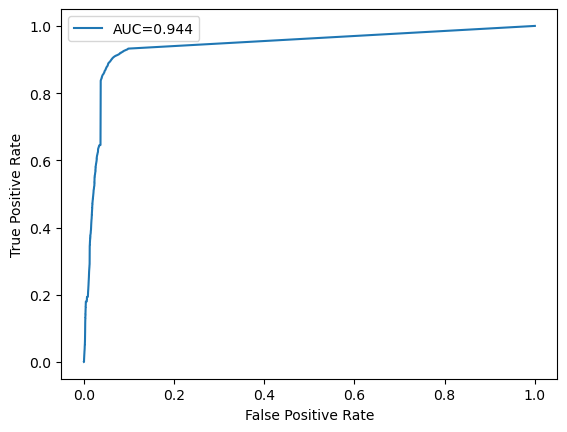

In [8]:
# Plot ROC curve
import numpy as np
from sklearn.metrics import roc_curve
import shap

# ROC curve
# collect true & predicted values
y_true, y_score = [], []
model.eval()
with torch.no_grad():
    for X,y in val_loader:
        X = X.to(device)
        y_true.extend(y.cpu().numpy())
        y_score.extend(model(X).sigmoid().cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, y_score)
plt.plot(fpr, tpr, label=f"AUC={best_auc:.3f}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.show()


